In [ ]:
#using collab GPU
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 7s (63.7 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+c

# IMPORTING TENSOERFLOW 


In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


directories follow from my google drive after linking it with google collabs

In [ ]:
root_Dir = '/content/drive/MyDrive/Strength NN/model_data'
source_Dir='/content/drive/MyDrive/Strength NN/raw_data'
local_weights_file = '/content/drive/MyDrive/Strength NN/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
categories=os.listdir(source_Dir)
print(categories)
#['SitUp_up', 'SitUp_down', 'BenchPress_up', 'PushUp_down', 'BenchPress_down', 'PushUp_up', 'PullUp_down', 'PullUp_up', 'Plank', 'Running']


['SitUp_up', 'SitUp_down', 'BenchPress_up', 'PushUp_down', 'BenchPress_down', 'PushUp_up', 'PullUp_down', 'PullUp_up']


#CREATING A TRAINING AND VALIDATION SET FROM MY RAW_DATA FILE
do not run following cells if model_data already had already been populated

creates validation and training directories

In [ ]:
if os.path.exists(root_Dir):
  shutil.rmtree(root_Dir)

def create_train_val_dirs(root_path):
    train_dir = os.path.join(root_path, 'training')
    os.makedirs(train_dir)
    validation_dir = os.path.join(root_path, 'validation')
    os.makedirs(validation_dir)
    for category in categories:
        train_category=os.path.join(train_dir,category)
        os.makedirs(train_category)
        validate_category=os.path.join(validation_dir,category)
        os.makedirs(validate_category)
try:
  create_train_val_dirs(root_path=root_Dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

helper function to split data into training and validation set. split_size is the percentage of data taht would be goin in to training and validation set

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  list_files=[]
  for rootdir, dirs, files in os.walk(SOURCE_DIR):
    list_files.append(files)
  
  length=len(list_files[0])
  list_files=random.sample(list_files[0],length)
  train_size=int(length*SPLIT_SIZE)
  count=0

  for file in list_files:
    dir= os.path.join(SOURCE_DIR,file)
    if(os.path.getsize(dir)>0):
      if(count<train_size):
        new_dir=os.path.join(TRAINING_DIR,file)
        copyfile(dir,new_dir)
        count=count+1
      else:
        new_dir=os.path.join(VALIDATION_DIR,file)
        copyfile(dir,new_dir)
        count=count+1
    else:
      print(file,"is zero length, so ignoring.")

splitting the data

In [ ]:
split_size = .8
for category in categories:
    source=os.path.join(source_Dir,category+"/")
    train=os.path.join(root_Dir,'training/'+category+"/")
    validate=os.path.join(root_Dir,'validation/'+category+"/")
    split_data(source, train, validate, split_size)

# CREATING TRAINING AND VALIDATION GENERATORS
**You may run the following cells
performs data augmentation on training data in essentially "increase variabililty in our data"

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode="categorical",
                                                      target_size=(300,300 ))
    
  validation_datagen = ImageDataGenerator(rescale=1.0/255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,  
                                                                class_mode="categorical",
                                                                target_size=(300, 300))
  return train_generator, validation_generator


In [ ]:
train=os.path.join(root_Dir,'training/')
validate=os.path.join(root_Dir,'validation/')
train_generator, validation_generator = train_val_generators(train, validate)

Found 869 images belonging to 8 classes.
Found 222 images belonging to 8 classes.


import the inception v3 ore-trained architecture. tensorflow allows for transfered learning. and this architecture works well for computer vision apparently.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

creating input layer and freezing nodes

In [ ]:
def create_pre_trained_model(local_weights_file):
    pre_trained_model = InceptionV3(input_shape = (300, 300, 3),
                                  include_top = False, 
                                  weights = None) 

    pre_trained_model.load_weights(local_weights_file)
    for layer in pre_trained_model.layers:
        layer.trainable = False
    return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

create a call back function to stop epochs if desired accuracies are achieved

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.85 and logs.get("val_accuracy")>.85):
              print("\nReached satisfactory accuracy so cancelling training!")
              self.model.stop_training = True

adjusting the last outpute layre of the inception v3 model

In [ ]:
def output_of_last_layer(pre_trained_model):
      last_desired_layer =pre_trained_model.get_layer('mixed7')
      print('last layer output shape: ', last_desired_layer.output_shape)
      last_output = last_desired_layer.output
      print('last layer output: ', last_output)
      return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 17, 17, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


building the dense layre to map to our data

In [ ]:
def create_final_model(pre_trained_model, last_output):
      x = tf.keras.layers.Flatten()(last_output)
      x = tf.keras.layers.Dense(1024, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.2)(x)
      x = tf.keras.layers.Dense  (len(categories), activation='softmax')(x) 
      model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)
        
      model.compile( optimizer = 'SGD',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])
      return model

In [ ]:
model = create_final_model(pre_trained_model, last_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# TRAINING THE MODEL
training for 100 epochs

In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    callbacks=callbacks) 

Epoch 1/100
44/44 [==============================] - 256s 6s/step - loss: 2.3052 - accuracy: 0.2175 - val_loss: 1.8067 - val_accuracy: 0.2207
Epoch 2/100
44/44 [==============================] - 21s 485ms/step - loss: 1.7080 - accuracy: 0.3049 - val_loss: 1.3572 - val_accuracy: 0.5000
Epoch 3/100
44/44 [==============================] - 21s 483ms/step - loss: 1.6012 - accuracy: 0.3337 - val_loss: 1.2684 - val_accuracy: 0.4459
Epoch 4/100
44/44 [==============================] - 21s 475ms/step - loss: 1.3995 - accuracy: 0.4028 - val_loss: 1.0780 - val_accuracy: 0.5541
Epoch 5/100
44/44 [==============================] - 21s 479ms/step - loss: 1.2941 - accuracy: 0.4568 - val_loss: 1.0229 - val_accuracy: 0.6306
Epoch 6/100
44/44 [==============================] - 22s 508ms/step - loss: 1.2452 - accuracy: 0.4776 - val_loss: 1.1414 - val_accuracy: 0.4324
Epoch 7/100
44/44 [==============================] - 21s 479ms/step - loss: 1.1874 - accuracy: 0.4787 - val_loss: 0.9321 - val_accuracy: 0

run follwoing cell to see how model performed over traineding and validation sets

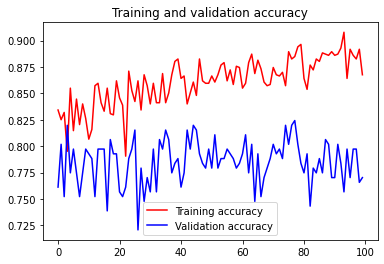

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
 
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

export serialised version of the model

In [ ]:
model.save_weights('/content/drive/MyDrive/Strength NN/weights3/')
model.save('/content/drive/MyDrive/Strength NN/trained_model3/')
#model=keras.models.load_model('')

run following if you wish to train the model for more epochs

In [ ]:
#model=tf.keras.models.load_model('/content/drive/MyDrive/Strength NN/trained_model3/')
#history = model.fit(train_generator,
#                    validation_data = validation_generator,
#                    epochs = 100,
#                    callbacks=callbacks)
#model.save_weights('/content/drive/MyDrive/Strength NN/weights3/')
#model.save('/content/drive/MyDrive/Strength NN/trained_model3/')

